In [157]:
from IPython.display import display, Math, Latex, HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import pdfkit

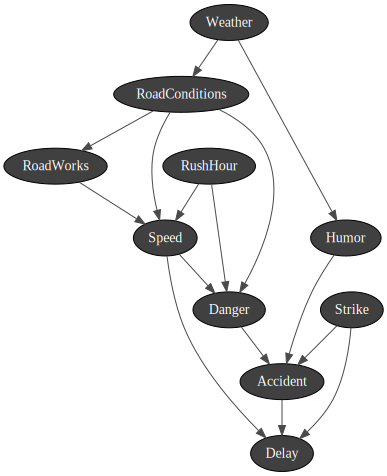

True

In [136]:
#construct network
m0 = gum.fastBN("Weather{Sun|Rain}->RoadConditions{Good|Bad}->RoadWorks{True|False}->Speed{Slow"
                "|Fast};Weather->Humor{Good|Bad}->Accident{True|False}->Delay{True|False}<-Strike{True|False"
                "}->Accident<-Danger{Low|High}<-Speed<-RushHour{True|False}->Danger<-RoadConditions->Speed->Delay;")


gnb.showBN(m0, size=10)
graph = gnb.BN2dot(m0, size=100)
graph.write_pdf('network.pdf')

In [104]:
def common_data(list1, list2): 
    result = False
    # traverse in the 1st list 
    for x in list1: 
        # traverse in the 2nd list 
        for y in list2: 
            # if one common 
            if x == y: 
                result = True
                return result 


def getAncestors(cm,varSet):
    ancestors=varSet

    while len(varSet)>0:
        newparents=cm.parents(varSet[0])
        newparents = [i for b in map(lambda x:[x] if not isinstance(x, list) else x, newparents) for i in b]
        newparents = [cm.names()[i] for i in newparents] 
        ancestors=ancestors+newparents
        varSet=varSet+newparents
        varSet.remove(varSet[0])
    return(ancestors)


def dSeparation(cm, varSet1, varSet2, evs):
    cmcopy=gum.fastBN("A")
    cmcopy.erase("A")
    [ cmcopy.add(name, 2) for name in cm.names()]
    for link in cm.arcs():
        cmcopy.addArc(*link)
    l1=cmcopy.names()
    l2=getAncestors(cmcopy,varSet1+varSet2+evs)
    #print(l2)
    l3 = [x for x in l1 if x not in l2]
    for i in l3:
        cmcopy.erase(i)
    m=cmcopy.moralGraph()
    if len(evs)>0:
        for i in evs:
            m.eraseNode(cmcopy.idFromName(i))
    #gnb.sideBySide(m)
    connComp=m.connectedComponents()
    #print(connComp)
    idVarSet1=[]
    idVarSet2=[]
    for i in varSet1:
        idVarSet1.append(cmcopy.idFromName(i))
    for i in varSet2:
        idVarSet2.append(cmcopy.idFromName(i))
    dSeparated=True
    for i in connComp:
        connCompSet=connComp[i]
        connCompSet= [i for b in map(lambda x:[x] if not isinstance(x, list) else x, connCompSet) for i in b]
        if common_data(connCompSet, idVarSet1) and common_data(connCompSet, idVarSet2):
            dSeparated=False
    del cmcopy
    return dSeparated


# D-separation


In [139]:
print(dSeparation(m0,["RushHour"], ["RoadConditions"], []))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Speed"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Strike"]))
print(dSeparation(m0,["RushHour"], ["RoadConditions"], ["Weather"]))

True
False
False
True
True


In [141]:
print(dSeparation(m0,["RushHour"], ["Strike"], []))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Delay"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Humor"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RushHour"], ["Strike"], ["Accident"]))

True
False
True
True
False


In [142]:
print(dSeparation(m0,["Speed"], ["Accident"], []))

False


In [144]:
print(dSeparation(m0,["RoadConditions"], ["Strike"], []))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RoadConditions"], ["Strike"], ["Delay"]))

True
True
False


In [146]:
print(dSeparation(m0,["RoadWorks"], ["Strike"], []))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Weather"]))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Danger"]))
print(dSeparation(m0,["RoadWorks"], ["Strike"], ["Delay"]))

True
True
True
False


# Conditional probability tables

In [159]:
m0.cpt("Weather")[:]=[0.5, 0.5]
m0.cpt("Strike")[:]=[0.1, 0.9]
m0.cpt("RushHour")[:]=[0.2, 0.8]

m0.cpt("RoadConditions")[{'Weather':'Sun'}]=[0.75, 0.25]
m0.cpt("RoadConditions")[{'Weather':'Rain'}]=[0.4, 0.6]

m0.cpt("Humor")[{'Weather':'Sun'}]=[0.8, 0.2]
m0.cpt("Humor")[{'Weather':'Rain'}]=[0.3, 0.7]

m0.cpt("RoadWorks")[{'RoadConditions':'Good'}]=[0.1, 0.9]
m0.cpt("RoadWorks")[{'RoadConditions':'Bad'}]=[0.8, 0.2]

m0.cpt("Speed")[{'RoadConditions':'Good', "RoadWorks":'True', 'RushHour':'True'}]=[0.85, 0.15]
m0.cpt("Speed")[{'RoadConditions':'Good', "RoadWorks":'True', 'RushHour':'False'}]=[0.75, 0.25]
m0.cpt("Speed")[{'RoadConditions':'Good', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m0.cpt("Speed")[{'RoadConditions':'Good', "RoadWorks":'False', 'RushHour':'False'}]=[0.15, 0.85]
m0.cpt("Speed")[{'RoadConditions':'Bad', "RoadWorks":'True', 'RushHour':'True'}]=[0.95, 0.05]
m0.cpt("Speed")[{'RoadConditions':'Bad', "RoadWorks":'True', 'RushHour':'False'}]=[0.9, 0.1]
m0.cpt("Speed")[{'RoadConditions':'Bad', "RoadWorks":'False', 'RushHour':'True'}]=[0.8, 0.2]
m0.cpt("Speed")[{'RoadConditions':'Bad', "RoadWorks":'False', 'RushHour':'False'}]=[0.6, 0.4]

m0.cpt("Danger")[{'RoadConditions':'Good', "Speed":'Slow', 'RushHour':'True'}]=[0.85, 0.15]
m0.cpt("Danger")[{'RoadConditions':'Good', "Speed":'Slow', 'RushHour':'False'}]=[0.95, 0.05]
m0.cpt("Danger")[{'RoadConditions':'Good', "Speed":'Fast', 'RushHour':'True'}]=[0.2, 0.8]
m0.cpt("Danger")[{'RoadConditions':'Good', "Speed":'Fast', 'RushHour':'False'}]=[0.3, 0.7]
m0.cpt("Danger")[{'RoadConditions':'Bad', "Speed":'Slow', 'RushHour':'True'}]=[0.45, 0.55]
m0.cpt("Danger")[{'RoadConditions':'Bad', "Speed":'Slow', 'RushHour':'False'}]=[0.55, 0.45]
m0.cpt("Danger")[{'RoadConditions':'Bad', "Speed":'Fast', 'RushHour':'True'}]=[0.05, 0.95]
m0.cpt("Danger")[{'RoadConditions':'Bad', "Speed":'Fast', 'RushHour':'False'}]=[0.2, 0.8]

m0.cpt("Accident")[{'Strike':'True', "Humor":"Good",'Danger':'Low'}]=[0.15, 0.85]
m0.cpt("Accident")[{'Strike':'True', "Humor":"Good",'Danger':'High'}]=[0.85, 0.15]
m0.cpt("Accident")[{'Strike':'True', "Humor":"Bad",'Danger':'Low'}]=[0.7, 0.3]
m0.cpt("Accident")[{'Strike':'True', "Humor":"Bad",'Danger':'High'}]=[0.95, 0.05]
m0.cpt("Accident")[{'Strike':'False',"Humor":"Good",'Danger':'Low'}]=[0.05, 0.95]
m0.cpt("Accident")[{'Strike':'False',"Humor":"Good",'Danger':'High'}]=[0.6, 0.4]
m0.cpt("Accident")[{'Strike':'False',"Humor":"Bad",'Danger':'Low'}]=[0.55, 0.45]
m0.cpt("Accident")[{'Strike':'False',"Humor":"Bad",'Danger':'High'}]=[0.8, 0.2]

m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'True'}]=[0.98, 0.02]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'True', 'Accident':'False'}]=[0.75, 0.25]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'True'}]=[0.95, 0.05]
m0.cpt("Delay")[{"Speed":'Slow', 'Strike':'False', 'Accident':'False'}]=[0.65, 0.35]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'True'}]=[0.9, 0.1]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'True', 'Accident':'False'}]=[0.6, 0.4]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'True'}]=[0.85, 0.15]
m0.cpt("Delay")[{"Speed":'Fast', 'Strike':'False', 'Accident':'False'}]=[0.45, 0.55]

# to draw network and cpt
gnb.sideBySide(m0.cpt("Weather"), m0.cpt("Strike"), m0.cpt("RushHour"), m0.cpt("RoadConditions"),  m0.cpt('Humor'), 
               m0.cpt("RoadWorks"), m0.cpt('Speed'), m0.cpt('Danger'),  m0.cpt('Accident'),  m0.cpt('Delay'))


In [161]:
# Save cpts to file

pdfkit.from_string(gnb.getPotential(m0.cpt("Weather"), digits=4),'weather.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Strike"), digits=4),'strike.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("RushHour"), digits=4),'rushhour.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("RoadConditions"), digits=4),'roadconditions.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Humor"), digits=4),'Humor.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("RoadWorks"), digits=4),'roadworks.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Speed"), digits=4),'speed.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Danger"), digits=4),'danger.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Accident"), digits=4),'accident.pdf')
pdfkit.from_string(gnb.getPotential(m0.cpt("Delay"), digits=4),'delay.pdf')


Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                         

True

# Causal Inference

## Calculate the causal effect of X on Y

In [148]:
#calculate P(Journey = True | Strike)
pGDP=m0.cpt("Journey")*m0.cpt("Strike")*m0.cpt("Weather")
pPatientgivenDrug=(pGDP.margSumOut(["Gender"])/pGDP.margSumOut(["Gender","Patient"])) #P(Patient|Drug)=P(Patient,Drug)/P(Drug)

pPatientgivenDrug.putFirst("Drug") # in order to have b horizontally in the table
pDrugTotal=pPatientgivenDrug.extract({'Patient':1}) #1 indicates "Healed"

# #calculate P(Patient = Healed | Gender=F, Drug)
# pPatientgivenGenderDrug=(pGDP)/pGDP.margSumOut(["Patient"])#P(Patient|Gender,Drug)=P(Patient,Drug,Gender)/P(Drug,Gender)
# pPatientgivenGenderDrug.putFirst("Drug")
# pDrugF=pPatientgivenGenderDrug.extract({'Patient':1,'Gender':0}) #1 indicates "Healed", 0 indicates F







NotFound: [pyAgrum] Object not found: hashtable's chained list contains no element with this key <Journey>